In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/home/sandeep/GoogleDrive/GTech/CS7643_DeepLearning/Project'

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import torch
from collections import Counter 
from itertools import chain 
import time
import math
import matplotlib.path
import numpy as np
from collections import Counter 
from itertools import chain 
import torch
import numpy as np
import matplotlib
import pickle as pkl

from matplotlib import pyplot as plt
from pathlib import Path
import os
import cv2
from collections import Counter
from itertools import chain
import os
from io import BytesIO
import base64
import sys
from datetime import datetime 
from flask import Flask, render_template, escape, send_from_directory, request, jsonify
from werkzeug.exceptions import RequestEntityTooLarge
from PIL import Image
import numpy as np
import cv2
import urllib
import validators
import requests
import json
import pdb
from collections import OrderedDict 
from shapely.geometry import LineString
from google.cloud.sql.connector import connector
import google.protobuf.text_format
from collections import Counter
import math
import shapely.geometry
from shapely.geometry.polygon import Polygon
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
import solaris as sol
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76,deltaE_ciede2000
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000, delta_e_cie1976,delta_e_cie1994
import pymysql
from common_utils.logging_util import *
from common_utils.utils import *
from common_utils.download_file import *
from common_utils.basic import *
from common_utils.time_keeper import *
from common_utils.download_utilities_v2 import *
from common_utils.geo_utils import *
import traceback2 as traceback

In [9]:
#Sunnyvale - Big area - Candidate
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.328858489991504,'lng': -122.06266534319472},
#                     'north_east': {'lat': 37.399259291969024,'lng': -121.99125421248486} 
#                 }
#                }

#Big area - Cupertino Markham
request_data = {'bounds': {
                    'south_west': {'lat':37.334709,'lng': -122.045922},
                    'north_east': {'lat': 37.341815, 'lng': -122.032667}
                }
               }

#Sunnyvale - test area from Candidate
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.3610508602018,'lng': -122.03247119744572},
#                     'north_east': {'lat': 37.36843030796058,'lng': -122.01931226276714} 
#                 }
#                }


#very small
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.31053927456226,'lng': -121.96162171079544}, 
#                     'north_east': {'lat': 37.312664815487345,'lng': -121.95861762771263}
#                 }
#                }

#mid-size
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.31053927456226,'lng': -121.96162171079544}, 
#                     'north_east': {'lat':  37.31606012232733,'lng': -121.950045297028}
#                 }
#                }

#Sunnyvale - Big area - Candidate
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.31617958096933,'lng': -122.07114167927428},
#                     'north_east': {'lat': 37.42149272953244,'lng': -121.94271754417488}
#                 }
#                }

# #Medium area
# request_data = {'bounds': {
#                     'south_west': {'lat': 37.31974452100154,'lng': -121.94507376440579},
#                     'north_east': {'lat': 37.32089517039027, 'lng': -121.94340795902154}
#                 }
#                }

In [10]:
bottom,left = request_data['bounds']['south_west']['lat'],request_data['bounds']['south_west']['lng']
top,right = request_data['bounds']['north_east']['lat'],request_data['bounds']['north_east']['lng']
bounds = [(top,left),(top,right),(bottom,right),(bottom,left)]

#top-left, bottom-right
(bounds[0],bounds[2]) 

((37.341815, -122.045922), (37.334709, -122.032667))

In [11]:
#Estimate the number of tiles to be read
estimate_tiles(bounds[0],bounds[2]) 

294

In [12]:
def create_horizontal_devides(topleft_ll, bottomright_ll, count=10):
    '''Creates count number of horizontal areas of equal size.
       params are:
           topleft_ll: (lat,long) of top-left of the candidate area
           bottomright_ll: (lat,long) of bottom-right of the candidate area
       returns:
           horizontal_devides: list of tuples of (topleft_ll, bottomright_ll) of count devides'''
    step_lat = (topleft_ll[0]-bottomright_ll[0])/count
    lats = []
    for i in range(11):
        lats.append(topleft_ll[0]-step_lat*i)

    tls = list(zip(lats[:-1], [topleft_ll[1]]*count))
    brs = list(zip(lats[1:], [bottomright_ll[1]]*count))
    horizontal_devides = list(zip(tls,brs))    
    return horizontal_devides

In [13]:
BUCKET_SAT_TILES = 'beans-satellite-map-tiles'
PATH_TILES_XY = '/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/images_home/tiles_xy'

#Default Tile download manager: it is related to one bucket location and and one local folder location
dlm = TileDownloadManager(BUCKET_SAT_TILES,PATH_TILES_XY )

In [14]:
def downloads_wrapper(area_topleft_bottomright_ll):
    ''' Downloads the tiles for the area specified as topleft and bottomright tuples of (lat,long)
    param:
        area_topleft_bottomright_ll: tuple of tuples of topleft and bottomright as (lat,long)
            e.g. ((37.341815, -122.045922), (37.3411044, -122.032667))
    returns:
        boolean value specifying if download was successful'''
    try:        
        tl_ll,br_ll = area_topleft_bottomright_ll
        tiles_grid_xy_d,tiles_grid_width_d,tiles_grid_height_d = create_tiles_xy_grid_for_area(tl_ll[0],tl_ll[1], br_ll[0],br_ll[1])
        tiles_grid_centers_d = {tiles_grid_xy_d[(x,y)]:xy2latlong(*tiles_grid_xy_d[(x,y)])  for x,y in tiles_grid_xy_d}

        dlm = TileDownloadManager(BUCKET_SAT_TILES,PATH_TILES_XY )
        dlm.collect_tiles_for_bounds((tl_ll,br_ll),maptype='satellite', local_download=True)
    except(e):
        print(f'\nNot able to download tiles for the area {area_topleft_bottomright_ll} \n',e)
        return False
    
    return True
    

In [15]:
horizontal_devides = create_horizontal_devides(bounds[0],bounds[2], count=10)

In [16]:
horizontal_devides

[((37.341815, -122.045922), (37.3411044, -122.032667)),
 ((37.3411044, -122.045922), (37.340393799999994, -122.032667)),
 ((37.340393799999994, -122.045922), (37.339683199999996, -122.032667)),
 ((37.339683199999996, -122.045922), (37.3389726, -122.032667)),
 ((37.3389726, -122.045922), (37.338262, -122.032667)),
 ((37.338262, -122.045922), (37.337551399999995, -122.032667)),
 ((37.337551399999995, -122.045922), (37.3368408, -122.032667)),
 ((37.3368408, -122.045922), (37.3361302, -122.032667)),
 ((37.3361302, -122.045922), (37.335419599999994, -122.032667)),
 ((37.335419599999994, -122.045922), (37.334709, -122.032667))]

In [17]:
#perform parallel download - repeat it for both types of images
st = datetime.now()

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

pool = mp.Pool(mp.cpu_count())

results = pool.map_async(downloads_wrapper, [hd for hd in horizontal_devides]).get()

pool.close()

datetime.now()-st

Number of processors:  12


datetime.timedelta(seconds=1, microseconds=721529)

In [18]:
#Create tile grid with (tile_x,tile_y) for whole area
tiles_grid_xy,tiles_grid_width,tiles_grid_height = create_tiles_xy_grid_for_area(*bounds[0], *bounds[2], zoom= 20)

TileDownloadManager is working fine for 'satellite' and 'basemap' both.

In [19]:
len(tiles_grid_xy)

294

In [20]:
def create_sliding_windows(tiles_grid_xy,filter_size=4, stride=2):
    ''' Creates filtered areas of filter_size x filter_size with shift of stride given.
        Corner filtered areas as resize to match only area of interests'''
    tiles_grid_height, tiles_grid_width  = np.max(np.array(list(zip(*list(tiles_grid_xy.keys()))))[0,:])+1, \
        np.max(np.array(list(zip(*list(tiles_grid_xy.keys()))))[1,:])+1
    grid_centers = np.zeros((tiles_grid_height, tiles_grid_width,2))     
    for r,c in tiles_grid_xy:
        grid_centers[r,c] = xy2latlong(*tiles_grid_xy[r,c])
        
    offset_width = tiles_grid_width%filter_size
    offset_height = tiles_grid_height%filter_size
    
    from itertools import product

    top_lefts = list() #top left index of each filter placements

    filtered_areas = [] 
    for t in range(0, tiles_grid_height-filter_size+1, stride):
        for l in range(0,tiles_grid_width-filter_size+1,stride):
            top_lefts.append([t,l])
            filtered_areas.append(grid_centers[t:t+filter_size, l:l+filter_size])
        if offset_width:
            last_t,last_l = top_lefts[-1]
            top_lefts.append([last_t,last_l+stride])
            filtered_areas.append(grid_centers[last_t:last_t+filter_size, last_l+stride:])

    if offset_height:
        t = top_lefts[-1][0]+stride
        for l in range(0,tiles_grid_width-filter_size+1,stride):
            top_lefts.append([t,l])
            filtered_areas.append(grid_centers[t:t+filter_size, l:l+filter_size])

        if offset_width:
            last_t,last_l = top_lefts[-1]
            filtered_areas.append(grid_centers[last_t:last_t+filter_size, last_l+stride:])
            
    
    return filtered_areas
 

In [21]:
def create_area_image(fa,tile_size=512,maptype='basemap',dlm=None):
    ''' builds the image of the area with given set of centers as (lat,long)
        params are:
            fa: filtered area as 2d array of centers of tiled area
            dlm: tile download manager. If not provided it creates new one.
        returns:
            fa_canvas: Built image of all the tiles with given centers.
            top-left tiles: tile_x,tile_y'''
    if not dlm:
        dlm = TileDownloadManager(BUCKET_SAT_TILES,PATH_TILES_XY )
        
    area_rows, area_cols = fa.shape[:2]
    fa_canvas = np.zeros((area_rows*tile_size, area_cols*tile_size, 3), dtype=np.uint8)
    for r in range(fa.shape[0]):
        for c in range(fa[r].shape[0]):
            fa_tile,fa_tile_center,fa_tile_path =  dlm.get_map_tile(fa[r,c], maptype=maptype)
            fa_canvas[r*tile_size:(r+1)*tile_size, c*tile_size:(c+1)*tile_size] = fa_tile  
    return fa_canvas, latlong2xy(*fa[0,0])

# def create_image_from_filtered_areas(filtered_areas,tile_size=512,maptype='satellite',dlm=None, construct_image=True):
#     ''' builds the image of all the areas with given as list of arrays of centers as (lat,long)
#         params are:
#             filtered_areas: list of filtered areas as each area is a 2d array of centers of tiled area
#             dlm: tile download manager. If not provided it creates new one.
#         returns:
#             canvas: Built image of all the tiles in all the filtered areas given centers.
#         '''
#     if not dlm:
#         dlm = TileDownloadManager(BUCKET_SAT_TILES,PATH_TILES_XY )

#     fas_merged = np.concatenate([fa.reshape(-1,2) for fa in filtered_areas])
#     fas_merged_xy = np.array(sorted(list(set([latlong2xy(*fa_ctr) for fa_ctr in fas_merged])), key=lambda xy:(xy[1],xy[0])))

#     xmax, xmin = fas_merged_xy[:,0].max(), fas_merged_xy[:,0].min()
#     ymax, ymin = fas_merged_xy[:,1].max(), fas_merged_xy[:,1].min()
#     width = xmax-xmin+1
#     height = ymax-ymin+1

#     canvas = np.zeros((height*512,width*512,3),dtype=np.uint8)
#     for xy in fas_merged_xy:
#         xy_img = dlm.get_map_tile(xy2latlong(*xy), maptype=maptype)
#         canvas[(xy[1]-ymin)*512:(xy[1]-ymin)*512+512,(xy[0]-xmin)*512:(xy[0]-xmin)*512+512] = xy_img[0]
        
#     #Find center of this image
#     topleft_ll = xy2latlong(xmin,ymin)
#     bottomright_ll = xy2latlong(xmax,ymax)
#     center_lat = bottomright_ll[0]+(topleft_ll[0]-bottomright_ll[0])/2
#     center_long = topleft_ll[1]+(bottomright_ll[1]- topleft_ll[1])/2
    
#     return canvas, (center_lat,center_long)


In [22]:
def create_image_from_filtered_areas(filtered_areas,tile_size=512,maptype='satellite',dlm=None, construct_image=True):
    ''' builds the image of all the areas with given as list of arrays of centers as (lat,long)
        params are:
            filtered_areas: list of filtered areas as each area is a 2d array of centers of tiled area
            dlm: tile download manager. If not provided it creates new one.
        returns:
            canvas: Built image of all the tiles in all the filtered areas given centers.
        '''
    if not dlm:
        dlm = TileDownloadManager(BUCKET_SAT_TILES,PATH_TILES_XY )

    fas_merged = np.concatenate([fa.reshape(-1,2) for fa in filtered_areas])
    fas_merged_xy = np.array(sorted(list(set([latlong2xy(*fa_ctr) for fa_ctr in fas_merged])), key=lambda xy:(xy[1],xy[0])))

    xmax, xmin = fas_merged_xy[:,0].max(), fas_merged_xy[:,0].min()
    ymax, ymin = fas_merged_xy[:,1].max(), fas_merged_xy[:,1].min()
    width = xmax-xmin+1
    height = ymax-ymin+1

    canvas_h = height*512
    canvas_w = width*512
    canvas = None
    if construct_image:        
        canvas = np.zeros((height*512,width*512,3),dtype=np.uint8)
        for xy in fas_merged_xy:
            xy_img = dlm.get_map_tile(xy2latlong(*xy), maptype=maptype)
            canvas[(xy[1]-ymin)*512:(xy[1]-ymin)*512+512,(xy[0]-xmin)*512:(xy[0]-xmin)*512+512] = xy_img[0]
    
    #Find center of this image
    topleft_ll = xy2latlong(xmin,ymin)
    bottomright_ll = xy2latlong(xmax,ymax)
    center_lat = bottomright_ll[0]+(topleft_ll[0]-bottomright_ll[0])/2
    center_long = topleft_ll[1]+(bottomright_ll[1]- topleft_ll[1])/2
    
    return canvas, (center_lat,center_long), (canvas_w, canvas_h)

In [23]:
#these filtered areas are 
filtered_areas = create_sliding_windows(tiles_grid_xy,filter_size=8, stride=4)
len(filtered_areas)

15

In [20]:
#Experimen - Just calculate center and height of whole area
create_image_from_filtered_areas(filtered_areas, construct_image=False)

(None, (37.36414600537059, -122.02686309814453), (53760, 66560))

In [24]:
img_h, img_h_center_ll, img_wh = create_image_from_filtered_areas(filtered_areas,maptype='satellite',construct_image=False)
# img_b, img_b_center_ll,img_wh = create_image_from_filtered_areas(filtered_areas,maptype='basemap',construct_image=False)

In [25]:
img_wh

(10752, 7168)

In [26]:
plt.imsave('img_h_cupertino_markham.png',img_h)
# plt.imsave('img_b_cupertino_fas.png',img_b)

AttributeError: 'tuple' object has no attribute 'shape'

In [29]:
# img_h_center,xy2latlong(*img_h_center)

In [30]:
# plt.figure(figsize=(15,15))
# plt.imshow(img_h)

In [31]:
# plt.figure(figsize=(15,15))
# plt.imshow(img_b)

In [23]:
def is_similar(plgn1, plgn2, polygons_ll, polygons_mdc):
    ''' find is two polygons have similar color profiel 
        params:
          plgn1: polygon number 1
          plgn2: polygon number 2
          polygons_ll: dict of <polygon number, shapely polygons using lat,lng>
          polygons_mdc: dict of <polygon number, most dominant color pair for polygon>
        returns:
          True is color is similar, else False'''
    plg1 = polygons_ll[plgn1]
    plg2 = polygons_ll[plgn2]
    
    dia1 = get_max_distance_between_polygon_pts(polygons_cr[plgn1])
    dia2 = get_max_distance_between_polygon_pts(polygons_cr[plgn2])
    dist = distance_euclidean(plg_centers_cr[plgn1],plg_centers_cr[plgn2])
    dia = min(dia1,dia2)  
    
    #similarity_threshold = 20.0
    #Adaptive value of similarity threshold is chosen on the basis of :
    #  1. size of buildings
    #  2. distance between building
    # If the buildings are near, we allow buildings with higher delta in color to be considered similar.
    # If the buildings are far, we allow buildings with lower delta in color to be considered similar.
    # In Summary, buildings which are far have to have really same color profile to be clustered together
    similarity_threshold = dia * 30 / dist
    
    
    if shapely_polygon_area(plg1)>1500 or shapely_polygon_area(plg2)>1500:
        similarity_threshold = similarity_threshold/2
    return color_pairs_match_check(polygons_mdc[plgn1],polygons_mdc[plgn2], color_delta_threshold=similarity_threshold)


In [24]:
PATH_IMGS_FILTERED_AREAS =  '/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/images_home/filtered_areas'

def process_each_filtered_area(fa):
    '''This is the top level method used for parallel processing each filtered area to extract:
        - All the polygon locations
        - All the properties of polygons needed for clustering
        params:
            fa: filtered area, which is area of one grid 
        returns: 
            '''
    area_base_img, area_tl_xy = create_area_image(fa,maptype='basemap')
    area_sat_img, area_tl_xy = create_area_image(fa,maptype='satellite')    
    
    print(f'\n Started processing for {area_tl_xy} , {fa[0][0]}')

    # We will do 2 things:
    # - Detect all the buildings as polygons in area_base_img.
    # - Build the color profile of the each polygons from area_sat_img.

    img_b = area_base_img #base
    img_h = area_sat_img  #sat
    
    ## TODO: paralallize
    adj_clrs = []
    # Find most colors adjacent to the road
    for r in range(img_b.shape[0]):
        for c in range(img_b.shape[1]):
            if all(img_b[r][c][:3] == np.array([0, 255, 0])):
                #img[r][c][0],img[r][c][1],img[r][c][2] = 0,0,0 
                clrs = get_surrounding_colors(img_b,(r,c),[])
                if len(clrs) >0:
                    adj_clrs.extend(clrs)
    
    # Count the frequency of colors
    c = collections.Counter(adj_clrs)   

    clrs_d = dict(c)
    # Sort the color as per their frequencies
    clrs_d = sorted( {(c, clrs_d[c]) for c in clrs_d},key=lambda kv: -kv[1] ) 
    
    img_road = show_colors(img_b, (0, 255, 0))
    img_blank = show_colors(img_b, (0, 0,0))
    img_water = show_colors(img_b, (170, 218,255))
    img_shades = show_colors(img_b, (245, 246,248))
    img_green = show_colors_range(img_b) #show_colors_green(input_imgb)
    img_whites = show_colors(img_b, (255, 255,255))
    img_whites2 = show_colors(img_b, (254, 254,254))    
    
    #Get masks for all prominant colors adjacent to the road
    clr_masks = []
    thres = clrs_d[0][1]//5  # consider all the masks with color counts in top 80 percentile only
    for cc in clrs_d:
        if cc[1]>thres: # Count more than 20 percentile from most frequent color count as 100%, i.e. only choose significantly frequnt colors
             clr_masks.append(show_colors(img_b, cc[0]))

    #Merge all the mutually exculsive color masks just by summing them, could have done OR as well.
    img_all_adj_clrs = np.array(clr_masks).sum(axis=0)
    if len(img_all_adj_clrs.shape) != 3:
        img_all_adj_clrs =  np.zeros(input_imgb.shape,dtype=np.uint8)

    #Merge adjacent color mask with road itself 
    img_road_plus_adj_clrs = img_road|img_blank|img_water|img_shades|img_green|img_whites|img_whites2|img_all_adj_clrs   

    #Invert the mask as everything which is not road or adjacent color to the road is building structure
    pred_mask = np.array((img_road_plus_adj_clrs == False).reshape(img_b.shape)*255, dtype=np.uint8)   

    #find all the polygons from mask
    mask2poly = sol.vector.mask.mask_to_poly_geojson(pred_mask, 
                                                     channel_scaling=[1,1,1], 
                                                     bg_threshold=245, 
                                                     simplify=True,
                                                     tolerance=3
                                                     )    
    #filter out smaller polygon
    mask2poly = mask2poly.loc[mask2poly['geometry'].area > 1000].copy()    
    
    # drop edge polygons
    mask2poly = mask2poly.loc[mask2poly['geometry'].map(lambda plg_t: not is_edge_polygon(img_h,plg_t))].copy()    
    
    # find all minimum rotated rectangle fitting the polygon
    mask2poly.loc[:,'rects'] = mask2poly['geometry'].map(lambda p: convert_polygon_to_xy(p.minimum_rotated_rectangle))

    # find all the original detected polygon's (col,row) coords
    mask2poly.loc[:,'polylines'] = mask2poly['geometry'].map(lambda p: convert_polygon_to_xy(p))    
    
    mask2poly.loc[:, 'geometry_shrink'] = mask2poly['geometry'].map(lambda p: shrink_or_swell_shapely_polygon(p))
    mask2poly.loc[:, 'polylines_shrink'] = mask2poly['geometry_shrink'].map(lambda p: convert_polygon_to_xy(p))    
    
    # find all the polgons
    polylines_xy = list(mask2poly['polylines'].values)
    polylines_xy_shrink = list(mask2poly['polylines_shrink'].values)    

    #Backup the original geometry and replace original with shrunk polygons
    mask2poly['geometry_bkup'] = mask2poly['geometry']
    mask2poly['geometry'] = mask2poly['geometry_shrink']   
    
    #Setup polygon ids for each polygon(New Shrunk polygons)
    polygons_cr =  OrderedDict(enumerate(sorted(list(mask2poly['geometry']),key=lambda plg: shape_polygon_to_leftmost_point(plg))))

    #Polygon centers as (col,row) in image
    plg_centers_cr = [shapely_shape_to_point(polygons_cr[plgn]) for plgn in polygons_cr]
    
    # #Convert all polygons to lat,long coords
    center_ll = get_center([fa[0][0],fa[-1][-1]])
    polygons_ll = {plgn:convert_polygon_colrow_to_polygon_latlng(polygons_cr[plgn],img_h, center_ll=center_ll)  for plgn in polygons_cr}
    
    #Center of each polyon
    plg_centers_ll = OrderedDict({pln: [polygons_ll[pln].representative_point().coords.xy[0][0],polygons_ll[pln].representative_point().coords.xy[1][0]] for pln in polygons_ll})
    #Center of each polygon to polygon number
    center2plgn = {tuple(plg_centers_ll[plgn]):plgn for plgn in plg_centers_ll}    
    
    #reduce salt and pepper noise
    img_s = filter_median(img_h,iterations=2) 
    #Make colors within polygons more homogeneous
    img_s = filter_bilateral(img_s,iterations=5)     
    
    #TODO: Replace with pred_mask : Single channel
    mask_simplified = annotate_polygons_filled_on_image(np.zeros_like(img_h), polylines_xy_shrink)
    exact_crops = crop_all_polygons_exactly(img_s,mask_simplified,polygons_cr)  
    
    #Find most dominant color for all the polygons of interest
    try:
        polygons_mdc = find_most_dominant_colors_for_all_plgns(exact_crops) #TODO: Parallalize this function
    except:
        print(f'\n Exception during processing for {area_tl_xy} , {fa[0][0]}')
        polygons_mdc = find_most_dominant_colors_for_all_plgns(exact_crops)
    
    print(f'\n Completed processing for {area_tl_xy} , {fa[0][0]}')
    return (latlong2xy(*fa[0][0]) ,[polygons_cr,plg_centers_cr, polygons_ll,plg_centers_ll,exact_crops,polygons_mdc])

In [25]:
#Load pr reprocess " if saved earlier 
fa_results = pkl.load( open ("fa_results.p", "rb") )
len(fa_results)

832

In [27]:
# #parallel process all the filtered areas
# st = datetime.now()
# print(st)
# import multiprocessing as mp
# print("Number of processors: ", mp.cpu_count())

# pool = mp.Pool(mp.cpu_count())

# fa_results = pool.map_async(process_each_filtered_area, [fa for fa in filtered_areas]).get()

# pool.close()
# datetime.now()-st

2021-07-27 18:54:40.202091
Number of processors:  12

 Started processing for (84465, 203354) , [  37.39061808 -122.00214386]

 Started processing for (84449, 203338) , [  37.39934637 -122.01313019]

 Started processing for (84433, 203358) , [  37.38843585 -122.02411652]
 Started processing for (84401, 203362) , [  37.38625356 -122.04608917]


 Started processing for (84417, 203342) , [  37.39716439 -122.03510284]

 Started processing for (84425, 203350) , [  37.39280025 -122.02960968]
 Started processing for (84457, 203346) , [  37.39498235 -122.00763702]
 Started processing for (84377, 203338) , [  37.39934637 -122.06256866]

 Started processing for (84441, 203366) , [  37.3840712  -122.01862335]



 Started processing for (84393, 203354) , [  37.39061808 -122.05158234]

 Started processing for (84385, 203346) , [  37.39498235 -122.0570755 ]

 Started processing for (84473, 203362) , [  37.38625356 -121.9966507 ]

 Completed processing for (84473, 203362) , [  37.38625356 -121.996650

 Completed processing for (84469, 203358) , [  37.38843585 -121.99939728]

 Started processing for (84473, 203358) , [  37.38843585 -121.9966507 ]

 Completed processing for (84393, 203358) , [  37.38843585 -122.05158234]

 Started processing for (84397, 203358) , [  37.38843585 -122.04883575]

 Completed processing for (84397, 203366) , [  37.3840712  -122.04883575]

 Started processing for (84401, 203366) , [  37.3840712  -122.04608917]

 Completed processing for (84421, 203346) , [  37.39498235 -122.03235626]

 Started processing for (84425, 203346) , [  37.39498235 -122.02960968]

 Completed processing for (84425, 203354) , [  37.39061808 -122.02960968]

 Started processing for (84429, 203354) , [  37.39061808 -122.0268631 ]

 Completed processing for (84381, 203350) , [  37.39280025 -122.05982208]

 Started processing for (84385, 203350) , [  37.39280025 -122.0570755 ]

 Completed processing for (84433, 203362) , [  37.38625356 -122.02411652]

 Started processing for (84437, 20336

Process ForkPoolWorker-25:
Traceback (most recent call last):
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-25-6a0897c03fe3>", line 28, in process_each_filtered_area
    if all(img_b[r][c][:3] == np.array([0, 255, 0])):
KeyboardInterrupt


KeyboardInterrupt: 

Process ForkPoolWorker-28:
Traceback (most recent call last):
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-33:
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Traceback (most recent call last):
  File "/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/multiprocessing/process.py", line 297, in _bootstra


 Started processing for (84377, 203374) , [  37.3797063  -122.06256866]

 Started processing for (84449, 203374) , [  37.3797063  -122.01313019]
 Started processing for (84417, 203378) , [  37.37752375 -122.03510284]

 Started processing for (84409, 203370) , [  37.38188878 -122.04059601]


 Started processing for (84385, 203382) , [  37.37534114 -122.0570755 ]

 Started processing for (84457, 203382) , [  37.37534114 -122.00763702]

 Completed processing for (84453, 203362) , [  37.38625356 -122.01038361]

 Started processing for (84457, 203362) , [  37.38625356 -122.00763702]

 Completed processing for (84409, 203358) , [  37.38843585 -122.04059601]

 Started processing for (84413, 203358) , [  37.38843585 -122.03784943]

 Completed processing for (84469, 203342) , [  37.39716439 -121.99939728]

 Started processing for (84473, 203342) , [  37.39716439 -121.9966507 ]


In [49]:
# #Save if want to cache results
# pkl.dump( fa_results, open( "fa_results.p", "wb" ) )

In [26]:
def find_nearest_points(all_points,query_point, count=1):
    ''' from query_point, finds count number of nearest points from all_points
        params:
            all_points: np array of all points in population, can be any nunber of dimensions in each point
            query_point: candidate point for which we want to find nearest points.
            count: how many nearest points we want from query_point
        returns:
            nearest_points: list of count number of points from all_points, nearest to query_points '''
    import numpy as np
    from collections import OrderedDict    
    import sklearn
    from sklearn.neighbors import BallTree
    
    #array with same index order as index_points keys
    all_points = np.array(all_points)  #in case if all_points is list of lists and not np array
    
    #Build the ball tree of all the records
    tree = BallTree(all_points, leaf_size=14)
    
    nearest_indices = tree.query(np.array(query_point).reshape(1,all_points.shape[1]), k=count+1)[1][0][1:].tolist()
    
    nearest_points = [list(all_points[idx]) for idx in nearest_indices]
    return nearest_points

# find_nearest_points(list(plg_centers.values()), [1750, 24],count=8)

def find_nearest_polygons(plg_centers_dict,number_of_neighbors=8):
    ''' Finds 'k' nearest points for each of polygons
    params:
        plg_centers_dict: dict of <polygon_number, polygon_center>
        number_of_neighbors: number of nearest polygons to find for each polygon (excluding self)
    returns:
        nearest_plgns: dict of <polygon_number: [list of 'number_of_neighbors' polygon_numbers in neighborhood] >'''
    import sklearn
    from sklearn.neighbors import BallTree
    import numpy as np
    from collections import OrderedDict
    
    #array with same index order as index_points keys
    plg_centers = np.array(list(plg_centers_dict.values())) 

    #Build the ball tree of all the records
    tree = BallTree(plg_centers, leaf_size=14)  

    nearest_plgns = OrderedDict({plgn: tree.query(np.array(plg_centers_dict[plgn]).reshape(1,2), k=number_of_neighbors+1)[1][0][1:].tolist() for plgn in plg_centers_dict})
    
    return nearest_plgns

In [27]:
#merge all the results into big dicts as:
polygons_cr = OrderedDict()
plg_centers_cr = list()
polygons_ll = OrderedDict()
plg_centers_ll = OrderedDict()
exact_crops = OrderedDict()
polygons_mdc = OrderedDict()

fa_2_startidx = OrderedDict()
plgn_idx = 0 #global polygon index
for idx_fa,fa_res in enumerate(fa_results):
    
    fa_2_startidx[idx_fa] = plgn_idx
    
    #1
    polygons_cr_fa = fa_res[1][0]
    for fa_idx in polygons_cr_fa:
        polygons_cr[plgn_idx+fa_idx] = polygons_cr_fa[fa_idx]
    #print(list(polygons_cr_fa.keys())[0] , ' : ' , len(polygons_cr_fa.keys()) )
    
    #2
    plg_centers_cr_fa = fa_res[1][1]
    plg_centers_cr.extend(plg_centers_cr_fa)
        
    #3
    polygons_ll_fa = fa_res[1][2]
    for fa_idx in polygons_ll_fa:
        polygons_ll[plgn_idx+fa_idx] = polygons_ll_fa[fa_idx]
    #print(list(polygons_ll_fa.keys())[0], ' : ' , len(polygons_ll_fa.keys()))
        
    #4
    plg_centers_ll_fa = fa_res[1][3]
    for fa_idx in plg_centers_ll_fa:
        plg_centers_ll[plgn_idx+fa_idx] = plg_centers_ll_fa[fa_idx]
    #print(list(plg_centers_ll_fa.keys())[0], ' : ' , len(plg_centers_ll_fa.keys()))
        
    #5
    exact_crops_fa = fa_res[1][4]
    for fa_idx in exact_crops_fa:
        exact_crops[plgn_idx+fa_idx] = exact_crops_fa[fa_idx]
    #print(list(exact_crops_fa.keys())[0], ' : ' , len(exact_crops_fa.keys()))
        
    #6
    polygons_mdc_fa = fa_res[1][5]
    for fa_idx in polygons_mdc_fa:
        polygons_mdc[plgn_idx+fa_idx] = polygons_mdc_fa[fa_idx]
    #print(list(polygons_mdc_fa.keys())[0], ' : ' , len(polygons_mdc_fa.keys()))
            
    plgn_idx += len(polygons_cr_fa) #start index of next filtered area


In [28]:
#remove duplicate polygons:
len(polygons_ll)

126972

In [29]:
# def find_overlapping_polygons(polygons_ll, threshold=0.05):
#     ''' reduced the overlapping polygons by keep just one of the overlapping.
#         extent of overlap is decided by threshold. 
#         With higher threshold of 0.95, we can reduce poygon to unique non-overlapping polygons
#         params:
#            polygons_ll: dictionary of polygons with id as key and polygon as shapely object
#            threshold: least extent to which Intersection-over-Union is considered overlapping
#         returns:
#             overlapping_groups: set of tuples, where each tuple of group of over-lapping polygon's ids '''
#     overlapping_groups = set()
#     #TODO: Change this n^2 approach to nearness based. check for transitive nearness
#     for plgn1 in polygons_ll:
#         dups = list()
#         dups.append(plgn1)
#         for plgn2 in polygons_ll:    
#             if plgn1!=plgn2 and is_overlapping(polygons_ll[plgn1],polygons_ll[plgn2],threshold=threshold):
#                 dups.append(plgn2)
#         overlapping_groups.add(tuple(sorted(list(dups))))
#     return overlapping_groups

In [30]:
# st = datetime.now()
# polygons_nearest = find_nearest_polygons(plg_centers_ll,number_of_neighbors=8)
# datetime.now()-st

In [31]:
def split_list(plgns_list):
    ''' Splits the list of polygon number in overlapping and non-overlapping polygons 
    params are:
       plgns_list: polygon numbers, these numbers are for polygons with mutual increasing distance   '''
    split_point = 0
    #pdb.set_trace()
    for i in range(len(plgns_list)-1):
        if not is_overlapping(polygons_ll[plgns_list[i]],polygons_ll[plgns_list[i+1]], threshold=0.5):
            split_point = i+1
            break
    return plgns_list[:split_point],plgns_list[split_point:]
      

In [32]:
# Duplicate Removal 

# sub 20 seconds
st = datetime.now()

#1.Build the tree
plg_centers_dict = plg_centers_ll.copy()
import sklearn
from sklearn.neighbors import BallTree
import numpy as np
from collections import OrderedDict
#array with same index order as index_points keys
plg_centers = np.array(list(plg_centers_dict.values())) 
#Build the ball tree of all the records
tree = BallTree(plg_centers, leaf_size=14)  

#2.Find unique and duplicate polygon numbers
unique_plgns = set()
duplicate_plgns = set()
for plgn in polygons_ll:
    #pdb.set_trace()
    if plgn in duplicate_plgns or plgn in unique_plgns :
        continue
    plgns_list = list(tree.query(np.array(plg_centers_dict[plgn]).reshape(1,2), k=16)[1][0])
    plgns_intersecting, plgns_non_intersecting = split_list(plgns_list)
    if plgns_intersecting:
        unique_plgns.add(plgn)
        if len(plgns_intersecting) > 1:
            plgns_intersecting_others = set(plgns_intersecting)
            plgns_intersecting_others.remove(plgn)
            duplicate_plgns.update(plgns_intersecting_others)
            for plgn_d in plgns_intersecting_others:
                if plgn_d in unique_plgns:
                    unique_plgns.remove(plgn_d)    
datetime.now()-st

datetime.timedelta(seconds=22, microseconds=231876)

In [33]:
#verify 
len(polygons_ll),len(duplicate_plgns),len(unique_plgns)

(126972, 90906, 36066)

In [34]:
plgns_deduped = unique_plgns.copy()

In [35]:
# print(str(datetime.now()))
# overlapping_groups = find_overlapping_polygons(polygons_ll)
# plgns_deduped = [tp[0] for tp in overlapping_groups]

In [36]:
#Verify all polygons are accounted in some group
# sum([len(tp) for tp in overlapping_groups])

In [37]:
#Purge all polygon to only have non-duplicate polygons
#merge all the results into big dicts as:
polygons_cr_new = polygons_cr.copy()
plg_centers_cr_new = list()
polygons_ll_new = polygons_ll.copy()
plg_centers_ll_new = plg_centers_ll.copy()
exact_crops_new = exact_crops.copy()
polygons_mdc_new = polygons_mdc.copy()

for plgn in polygons_ll:
    if plgn not in plgns_deduped:
        polygons_cr_new.pop(plgn)
        polygons_ll_new.pop(plgn)
        plg_centers_ll_new.pop(plgn)
        exact_crops_new.pop(plgn)
        polygons_mdc_new.pop(plgn)
    else:
        plg_centers_cr_new.append(shapely_shape_to_point(polygons_cr[plgn].representative_point()))

In [38]:
#Reindex all the dicts. 
polygons_cr = OrderedDict(enumerate(polygons_cr_new.values()))
polygons_ll = OrderedDict(enumerate(polygons_ll_new.values()))
plg_centers_ll = OrderedDict(enumerate(plg_centers_ll_new.values()))
exact_crops = OrderedDict(enumerate(exact_crops_new.values()))
polygons_mdc = OrderedDict(enumerate(polygons_mdc_new.values()))
plg_centers_cr = plg_centers_cr_new

In [39]:
len(polygons_ll),len(polygons_cr),len(plg_centers_ll),len(exact_crops),len(polygons_mdc),len(plg_centers_cr)

(36066, 36066, 36066, 36066, 36066, 36066)

Now, we have all the filtered areas processes and all the polygons and their information have been collected as below: 

1. Detected all the buildings as polygons in each filtered area. 
2. Built the color profile of the each polygons from satellite image of each filtered area. 


#### Now, we have following things:


polygons_cr : dict of polygon number to shapely polygon with col,row as coords.

plg_centers_cr : (col,row) center of each polygon 

polygons_ll :  dict of polygon number to shapely polygon with lat,lng as coords.

plg_centers_ll : (lat,long) center of each polygon 

exact_crops : image crop of the building polygon from satellite image 

polygons_mdc = 2 most prominant colors of each polygon



### Build neighborhood using: 8 nearest and similar roof dominant color

In [40]:
center_h = img_h_center_ll
polygons_cr = {plgn:convert_polygon_latlng_to_polygon_colrow(polygons_ll[plgn],img_wh)  for plgn in polygons_ll}

In [41]:
# building mapping of polygon center's (col,row) to polygon number 
center2plgn_cr = {get_imagetilepoint_from_latlng(*img_h_center_ll,*shapely_shape_to_point(polygons_ll[plgn].representative_point())[::-1],tile_size_h=img_wh[1],tile_size_w=img_wh[0]):plgn for plgn in polygons_ll}
plgn2center_cr = {center2plgn_cr[pctr]:pctr for pctr in center2plgn_cr}
#list of centers
plg_centers_cr = list(plgn2center_cr.values())

In [42]:
def find_angle(plg_ctr1, plg_ctr2):
    '''  '''
    return (math.atan2(plg_ctr1[0]-plg_ctr2[0], plg_ctr1[1]-plg_ctr2[1])*180/math.pi)+180
    
# def find_closest_nbrs(plg_ctr, count=4):
#     ''' finds the closest neighbors by deviding field of view 
#         from candidate polygon center in count number of slices. 
#         In each slice, we select the closest neighbor'''   
#     bucket_distance = [0]*count
#     bucket_candidate = [None]*count
#     #TODO: n^n: Instead searching for all centers, just find 1000 or so nearest by distance
#     for ctr in plg_centers_cr:
#         if ctr == plg_ctr:
#             continue
#         idx = int(find_angle(ctr, plg_ctr)*count/360)
#         idx = idx%count
#         #print(idx)
#         dist = distance_euclidean(ctr,plg_ctr)
#         if bucket_candidate[idx] is None:
#             bucket_candidate[idx] = ctr
#             bucket_distance[idx] = dist
#         else:
#             if dist < bucket_distance[idx]:
#                 bucket_candidate[idx] = ctr
#                 bucket_distance[idx] = dist
#     return [center2plgn_cr[cctr] for cctr in bucket_candidate if cctr is not None ] 

def find_closest_nbrs(plg_ctr,plgn2center_cr, count=4):
    ''' finds the closest neighbors by deviding field of view 
        from candidate polygon center in count number of slices. 
        In each slice, we select the closest neighbor'''   
    bucket_distance = [0]*count
    bucket_candidate = [None]*count
    #TODO: n^n: Instead searching for all centers, just find 1000 or so nearest by distance
    for plgn in plgn2center_cr:
        if plgn2center_cr[plgn] == plg_ctr:
            continue
        idx = int(find_angle(plgn2center_cr[plgn], plg_ctr)*count/360)
        idx = idx%count
        #print(idx)
        dist = distance_euclidean(plgn2center_cr[plgn],plg_ctr)
        if bucket_candidate[idx] is None:
            bucket_candidate[idx] = plgn
            bucket_distance[idx] = dist
        else:
            if dist < bucket_distance[idx]:
                bucket_candidate[idx] = plgn
                bucket_distance[idx] = dist
    return [plgn for plgn in bucket_candidate if plgn is not None ] 


In [43]:
# shapely_shape_to_point(polygons_cr[0]), plg_centers_cr[0]
find_closest_nbrs(plgn2center_cr[0],plgn2center_cr,count=8)
# plgn2center_cr[0]

[1, 19, 6, 9, 13662]

In [59]:
# TODO: Use the tree to find nearest polygons, 
# #1.Build the tree
# import sklearn
# from sklearn.neighbors import BallTree
# import numpy as np
# from collections import OrderedDict
# plg_centers_cr_arr = np.array(list(plgn2center_cr.values())) 
# #Build the ball tree of all the records
# tree_centers_cr = BallTree(plg_centers_cr_arr, leaf_size=14)  

In [44]:
#takes almost 30 mins with n*n
st = datetime.now()
#Find 8 sided nieghbors for each polygon center
nearest_plgns_ctr = {plgn2center_cr[plgn]: find_closest_nbrs(plgn2center_cr[plgn],plgn2center_cr,count=8) for plgn in plgn2center_cr}
#get polygon nubers to nearest polygons list
nearest_plgns = { center2plgn_cr[pctr]:nearest_plgns_ctr[pctr] for pctr in  nearest_plgns_ctr }
datetime.now()- st

datetime.timedelta(seconds=3076, microseconds=660845)

In [45]:
#Verify if nearest neighbors are correctly calculated
plgn_c = 100 
print(f'Center polygon :{plgn_c}:  {shapely_shape_to_point(polygons_ll[plgn_c])[::-1]}')
for plgn in nearest_plgns[plgn_c]:
    print(f'Nieghbor polygon :{plgn}:  {shapely_shape_to_point(polygons_ll[plgn])[::-1]}')
    

Center polygon :100:  (37.398829593047566, -122.05941977915103)
Nieghbor polygon :86:  (37.39884235264535, -122.05994770870446)
Nieghbor polygon :98:  (37.39921744300499, -122.05961450432594)
Nieghbor polygon :106:  (37.399095457540014, -122.05930642783642)
Nieghbor polygon :107:  (37.398930134795265, -122.05923103073593)
Nieghbor polygon :113:  (37.398653962998296, -122.05858498531632)
Nieghbor polygon :104:  (37.398708792807106, -122.05939280874003)
Nieghbor polygon :103:  (37.39838534880296, -122.05942176282406)
Nieghbor polygon :87:  (37.3984630391986, -122.05989897147657)


In [46]:
def build_neighborhood_for_polygons( polygons_ll, nearest_plgns, plg_centers_cr):
    ''' For every polygon, builds the nieghborhood on the basis of:
        1. nearest polygons
        2. color similarity of polygons
        '''
    #points = [[1080, 550], [1480, 550]]
    from collections import OrderedDict
    neighbor_polygons = {} #key is plgn(polygon number) and value is list of plgns, which are nearest to key plgn
    #imgl = img.copy()
    for plgn in polygons_ll:
        #plg = polygons[plgn]
        ##nearest_polygons[pt_index] = (nearest_polygon_for_point(img, pt, polygons)[-1],pt)
        #for pn in polygons:
        #    plgn_nears = OrderedDict()
        #    if plgn != pn:
        #        pt1,pt2,dist = nearest_points_for_polygons_pair(polygons[plgn],polygons[pn])
        #        plgn_nears[pn] = (pt1,pt2,dist)
        #plgn_nears = OrderedDict(sorted(plgn_nears.items(), key=lambda t: -t[1][2])[:4])#choose 4 nearests
        plgn_nearests = nearest_plgns[plgn] #8 nearest polygon numbers
        
        #Out of 8 nearest polygons, drop the ones which does not have matching roof.
        for i,pn in enumerate(plgn_nearests):
            #if not color_pairs_match_check(polygons_mdc[plgn],polygons_mdc[pn]):
            if not is_similar(plgn, pn, polygons_ll, polygons_mdc):
                plgn_nearests.pop(i)
        
        neighbor_polygons[plgn] = plgn_nearests  #Only polygons, which are nearest and have similar roof color
        #for pn in plgn_nearests:
        #    draw_line(imgl, plg_centers_cr[plgn],plg_centers_cr[pn])
    return neighbor_polygons 

In [47]:
#Takes almost 12 minutes
st = datetime.now()
#Build final neighborhood using distance nearness and color profile of polygons
neighbor_polygons  = build_neighborhood_for_polygons(polygons_ll,nearest_plgns, plg_centers_cr)
datetime.now()-st

datetime.timedelta(seconds=444, microseconds=433630)

#### What we have got till now

polygons_cr, polygons_ll, polygons_mdc

plg_centers_cr, plg_centers_ll

nearest_plgns, neighbor_polygons

### Load parcels as geo data frame

In [48]:
# parcels_file = '/home/sandeep/Desktop/git-repos/beans-ai-building-clustering/parcels/parcels_selected_6_15.json'
# import geopandas as gpd
# pdf = gpd.read_file(parcels_file)
# parcels_ll = dict(enumerate(list(pdf['geometry'])))
# prcl_ids_multipolygon = [prcl_id for prcl_id in parcels_ll if type(parcels_ll[prcl_id]) == shapely.geometry.multipolygon.MultiPolygon ]
# #Delete all multi-polygon parcels
# for prcl_id in prcl_ids_multipolygon:
#     parcels_ll.pop(prcl_id)
# pdf['geometry'].plot(figsize=(20,20))

In [49]:
parcels_file = '/home/sandeep/Desktop/beans-home/git-repos/beans-ai-building-clustering/parcels/sunnyvale.json'
# parcels_file = '/home/sandeep/Desktop/beans-home/git-repos/beans-ai-building-clustering/parcels/parcels_selected_6_15.json'
# parcels_file = '/home/sandeep/Desktop/beans-home/git-repos/beans-ai-building-clustering/parcels/cupertino.geojson'

In [50]:
import geopandas as gpd

In [51]:
pdf = gpd.read_file(parcels_file)
parcels_ll = dict(enumerate(list(pdf['geometry'])))

In [52]:
prcl_ids_multipolygon = [prcl_id for prcl_id in parcels_ll if type(parcels_ll[prcl_id]) == shapely.geometry.multipolygon.MultiPolygon ]
len(prcl_ids_multipolygon)

39

In [53]:
#Delete all multi-polygon parcels
for prcl_id in prcl_ids_multipolygon:
    parcels_ll.pop(prcl_id)
len(parcels_ll)

73854

<AxesSubplot:>

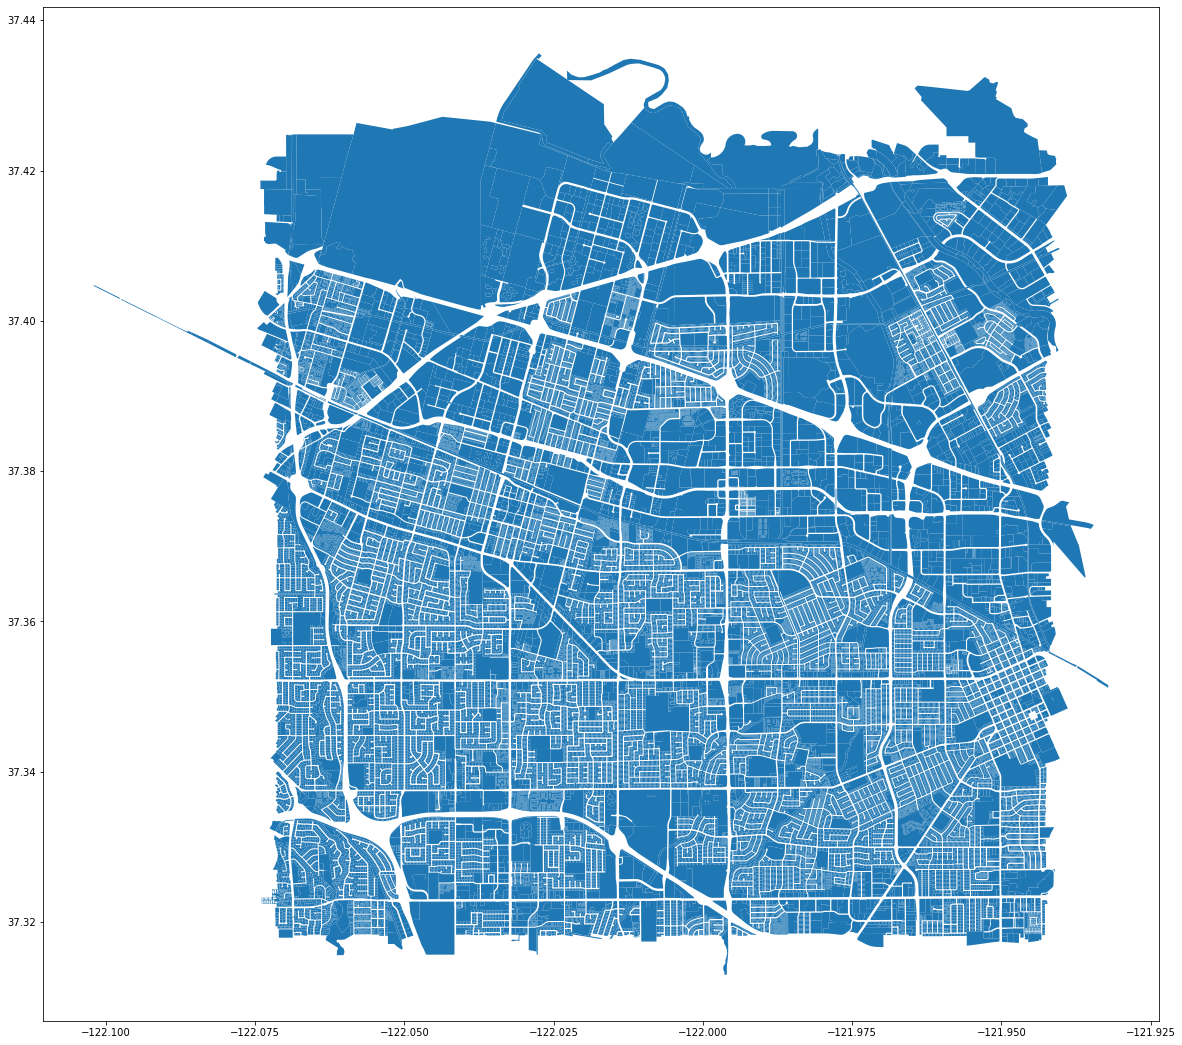

In [54]:
pdf['geometry'].plot(figsize=(20,20))

In [55]:
def is_polygon_in_parcel(plg,prcl):
    ''' Returns True if representative point of polygon is in parcel,else False
        Note that plg and parcel, both have coords in lat,lng'''
    return prcl.contains(plg.representative_point())

def get_polygons_in_parcel(parcel, polygons_ll,tree):
    ''' Finds list of polygons, which falls within parcel at hand
        params: 
           parcel : as shapely polygon
           polygons_ll: dict of all buildings as shapely polygons using lat,lng
        returns:
           polygons_within: set of all the polygon numbers within parcel
           '''
    plgns_within = []
    parcel_center = shapely_shape_to_point(parcel.representative_point())
    no_of_polygons = 1000 if len(polygons_ll) > 1000 else len(polygons_ll)
    plgns_list = list(tree.query(np.array(parcel_center).reshape(1,2), k=no_of_polygons)[1][0])
    for plgn in plgns_list:
        if is_polygon_in_parcel(polygons_ll[plgn], parcel):
            plgns_within.append(plgn)
    return set(plgns_within)

In [56]:
#1.Build the tree
import sklearn
from sklearn.neighbors import BallTree
import numpy as np
from collections import OrderedDict
#array with same index order as index_points keys
plg_centers = np.array(list(plg_centers_ll.values())) 
#Build the ball tree of all the records
tree = BallTree(plg_centers, leaf_size=14)  

In [57]:
## takes almost 15 minutes
st = datetime.now()

inputBuildings = list(polygons_cr.keys())
clusters = []
clusterByBuilding = {}
clusteredBuildings = inputBuildings.copy()

# Make clusters by parcel
clusters_by_parcel_plgns = {}
for prcl_n in parcels_ll:
    buildings = get_polygons_in_parcel(parcels_ll[prcl_n],polygons_ll,tree)
    clusters_by_parcel_plgns[prcl_n] = buildings
    for bldg_n in buildings:
        clusterByBuilding[bldg_n] = buildings
    clusters.append(buildings);
    for bldg_n in buildings:
        if bldg_n in clusteredBuildings:
            clusteredBuildings.remove(bldg_n)
            
for bldg_n in clusteredBuildings:
    singular_clstr = set([bldg_n])
    clusters.append(singular_clstr)
    clusterByBuilding[bldg_n] = singular_clstr

for bldg_n in inputBuildings:
    nearbyBuildings = nearest_plgns[bldg_n]
    for near_bldg_n in nearbyBuildings:
        if clusterByBuilding[bldg_n] == clusterByBuilding[near_bldg_n]:
            continue;
        if is_similar(bldg_n, near_bldg_n, polygons_ll, polygons_mdc):
            cluster = set()
            cluster.update(clusterByBuilding[bldg_n])
            cluster.update(clusterByBuilding[near_bldg_n])
            clusters.remove(clusterByBuilding[bldg_n])
            clusters.remove(clusterByBuilding[near_bldg_n])
            clusters.append(cluster)
            for cbldg_n in cluster:
                clusterByBuilding[cbldg_n] = cluster 

datetime.now()-st

datetime.timedelta(seconds=1039, microseconds=1821)

In [58]:
clusters_dict = OrderedDict(enumerate(list(clstr) for clstr in clusters if len(clstr)))

In [59]:
#takes almost 10 minutes
st = datetime.now()
#NEW - Build polygon to parcel number mapping
polygon2parclnum = dict()
for prcl_n in parcels_ll:
    plgns = get_polygons_in_parcel(parcels_ll[prcl_n],polygons_ll,tree)
    for plgn in plgns:
        polygon2parclnum[plgn] = prcl_n
datetime.now()-st

datetime.timedelta(seconds=639, microseconds=270248)

In [60]:
#Sort by cluster size
# clusters_by_parcel_plgns = OrderedDict(sorted(clusters_by_parcel_plgns.items(), key = lambda kv:len(kv[1])))

In [61]:
# from shapely.ops import cascaded_union
# cu = cascaded_union([polygons_ll[361],polygons_ll[410],polygons_ll[435],polygons_ll[437],polygons_ll[439]])
#361, 410, 435, 437, 439
# cu

In [62]:
def annotate_clusters_on_img(anno_img, clusters_list):
    ''' Annotates passed image with width,height coordinate location '''
    for cl_idx,cl in enumerate(clusters_list):
        if len(cl)==0:
            continue
        cluster_color = get_random_color()
        anno_img = annotate_points_on_image(anno_img, cl,color=cluster_color,cluster_id=cl_idx)
        #pdb.set_trace()
        cla = np.array(cl)
        clusterxy = (int(sum(cla[:,0])/cla.shape[0]),int(sum(cla[:,1])/cla.shape[0]))
        #anno_img = annotate_cicle(anno_img, clusterxy, radius=40,color=cluster_color, thickness=5)
        #annotate_text(anno_img, clusterxy,cl_idx, cluster_color,size=6.0, font=cv2.FONT_HERSHEY_TRIPLEX)
    return anno_img

def fill_polygons_transparent(canvas, polylines_xy,alpha=0.2,color=(255,255,0)):
    '''Draw all the polygons provides as list of [col,row] lists
       params are:
           canvas: numpy image array, on which polygons are to be drawn
           polylines_xy: polygons as list of [col,row] lists
           '''
    from PIL import Image, ImageDraw, ImageFont
    polylines_xy = [[tuple(xy) for xy in pl_xy] for pl_xy in polylines_xy]
    canvas_pil = Image.fromarray(np.uint8(canvas.copy())).convert('RGB')
    pdraw = ImageDraw.Draw(canvas_pil,'RGBA')
    for pl_xy in polylines_xy:
        pdraw.polygon(pl_xy,fill=(*color,int(255*alpha)),outline=(255,255,255,255))
    del pdraw
    return np.array(canvas_pil)

# def annotate_clusters_on_img_new(anno_img, clusters_dict, alpha=0.2):
#     ''' Annotates passed image with width,height coordinate location '''
#     for cl_idx in clusters_dict:
#         cl_plgns = clusters_dict[cl_idx]
#         cl = [ [int(plgn2center_cr[plgn][0]), int(plgn2center_cr[plgn][1])] for plgn in cl_plgns ]
#         polylines_xy = [ convert_polygon_to_xy(polygons_cr[plgn]) for plgn in cl_plgns if len(cl_plgns)]
#         if len(cl)==0:
#             continue
#         cluster_color = get_random_color()
#         anno_img = annotate_points_on_image(anno_img, cl,color=cluster_color,cluster_id=cl_idx)
#         anno_img = fill_polygons_transparent(anno_img, polylines_xy,alpha=alpha,color=cluster_color)
        
#     return anno_img

def annotate_clusters_on_img_new(anno_img, clusters_dict, alpha=0.2):
    ''' Annotates passed image with width,height coordinate location '''
    for cl_idx in clusters_dict:
        cl_plgns = clusters_dict[cl_idx]
        cl = [ [int(plgn2center_cr[plgn][1]), int(plgn2center_cr[plgn][0])] for plgn in cl_plgns ]
        polylines_xy = [ convert_polygon2list(polygons_cr[plgn]) for plgn in cl_plgns if len(cl_plgns)]
        if len(cl)==0:
            continue
        cluster_color = get_random_color()
        anno_img = annotate_points_on_image(anno_img, cl,color=cluster_color,cluster_id=cl_idx)
        anno_img = fill_polygons_transparent(anno_img, polylines_xy,alpha=alpha,color=cluster_color)
        
    return anno_img


In [57]:
clusters_dict

OrderedDict([(0, [9024, 9031]),
             (1, [31603]),
             (2, [29261]),
             (3, [17713]),
             (4, [15870]),
             (5, [14274, 12978]),
             (6, [22097]),
             (7, [10202, 9338]),
             (8, [15065]),
             (9, [3381]),
             (10, [17707]),
             (11, [3913]),
             (12, [29386]),
             (13, [20730]),
             (14, [35514]),
             (15, [15076]),
             (16, [30714, 30715]),
             (17, [27680, 27675, 27679]),
             (18, [14292, 14293]),
             (19, [8570]),
             (20, [35680]),
             (21, [9560]),
             (22, [31647]),
             (23, [27596]),
             (24, [34961]),
             (25, [17474]),
             (26, [11983]),
             (27, [31988]),
             (28, [11664]),
             (29, [8983]),
             (30, [31277]),
             (31, [23850]),
             (32, [18127]),
             (33, [27130]),
             (34,

In [62]:
plgn2center_cr[7]

(1099, 222)

In [58]:
#check
plgn2center_cr[7]

(1099, 222)

In [80]:
#Clusters by parcels only
clusters_by_prcls =  [ clusters_by_parcel_plgns[cidx] for cidx in clusters_by_parcel_plgns]
clusters_by_prcls_list = [ [[int(plg_centers_cr[plgn][0]), int(plg_centers_cr[plgn][1])] for plgn in list(c) ]  for c in clusters_by_prcls ]
# img_h_clusteredbyparcels = annotate_clusters_on_img(img_h.copy(), clusters_by_prcls_list)
# plt.imsave('fas_img_h_markham_clusteredbyparcels.png', img_h_clusteredbyparcels)

In [81]:
#Vis 1
# Clusters by parcels and neighborhood(nearness + color similarity)
clusters_list = [ [[int(plg_centers_cr[plgn][0]), int(plg_centers_cr[plgn][1])] for plgn in list(c) ]  for c in clusters ]
# img_h_clustered = annotate_clusters_on_img(img_h.copy(), clusters_list)
# plt.imsave('fas_img_h_markham_img_overlaid_clustered.png', img_h_clustered)

In [82]:
# #Vis 2 with transparency 
# #Clusters by parcels and neighborhood(nearness + color similarity)
# st= datetime.now()
# img_h_clustered_alpha = annotate_clusters_on_img_new(img_h.copy(), clusters_dict, alpha=0.2)
# plt.imsave('fas_img_h_markham_img_overlaid_clustered_alpha0.2.png', img_h_clustered_alpha)
# print(datetime.now()-st)

In [83]:
# plt.figure(figsize=(15,15))
# plt.imshow(img_h_clustered_alpha)

## Split clusters if they form better smaller clusters 

We are going to search for number of splits k, which can provide lowest overall distance measure.

In [84]:
len(clusters)

60212

In [85]:
#check
len(clusters)

60212

In [86]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np

In [87]:
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(clstr_plgn):
    clstr_centers_cr = [ plgn2center_cr[plgn] for plgn in clstr_plgn]
    #sil = []
    k2sil = OrderedDict()
    kmax = len(clstr_plgn)-1
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(np.array(clstr_centers_cr))
        labels = kmeans.labels_
        sil_score = silhouette_score(np.array(clstr_centers_cr), labels, metric = 'euclidean')
        #sil.append(sil_score)
        k2sil[k]= sil_score
    return k2sil

def calculate_WSS(clstr_plgn, kmax=1):
    clstr_centers_cr = [ plgn2center_cr[plgn] for plgn in clstr_plgn]
    points = np.array(clstr_centers_cr)
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    
    return sse

def calculate_WSS_klist(clstr_plgn, klist=[1]):
    clstr_centers_cr = [ plgn2center_cr[plgn] for plgn in clstr_plgn]
    points = np.array(clstr_centers_cr)
    sse = OrderedDict()
    for k in klist:
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse[k]= curr_sse

    return sse

def perform_best_splits(clstr_plgns):
    ''' tried to perform best possible cluster split on the basis of:
        - by maximizing silhouette score
        - by minimizing total squared-sum of distances of all points from their cluster centroid
        params are:
        - clstr_plgns: cluster to be split as a list of polygon numbers
        '''
    k2sil = calculate_silhouette_scores(clstr_plgns)
    percentile_cutoff = np.percentile(list(k2sil.values()), 80)
    k_candidates = []
    for k in k2sil:
        if k2sil[k] >= percentile_cutoff:
            k_candidates.append(k)    
    k2cwss = calculate_WSS_klist(clstr_plgns,klist=k_candidates)
    k_final = k_candidates[np.argmin(list(k2cwss.values()))]
    final_clusters = make_k_clusters(clstr_plgns, k=k_final)
    return final_clusters
    
def make_k_clusters(plgn_list, k=1):
    ''' Splits the cluster in k clusters using euclidean distance measure '''
    
    clstr_centers_cr = [ plgn2center_cr[plgn] for plgn in plgn_list]
    points = np.array(clstr_centers_cr)
    
    kmeans = KMeans(n_clusters = k).fit(points)
    pred_clusters = kmeans.predict(points)
    
    clusters = []
    for l in set(kmeans.labels_):
        lidx = list(np.argwhere(pred_clusters==l).reshape(-1))
        lclstr = points[lidx].tolist()
        clusters.append([center2plgn_cr[tuple(plgn_ctr_cr)] for plgn_ctr_cr in lclstr])
        
    return clusters 

(array([9.763e+03, 2.798e+03, 1.003e+03, 5.410e+02, 3.110e+02, 2.110e+02,
        1.430e+02, 8.900e+01, 8.700e+01, 6.300e+01, 3.800e+01, 3.300e+01,
        2.700e+01, 2.600e+01, 2.200e+01, 1.200e+01, 1.700e+01, 1.200e+01,
        1.400e+01, 9.000e+00, 5.000e+00, 9.000e+00, 1.300e+01, 5.000e+00,
        3.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 4.000e+00]),
 array([ 1.        ,  1.96666667,  2.93333333,  3.9       ,  4.86666667,
         5.83333333,  6.8       ,  7.76666667,  8.73333333,  9.7       ,
        10.66666667, 11.63333333, 12.6       , 13.56666667, 14.53333333,
        15.5       , 16.46666667, 17.43333333, 18.4       , 19.36666667,
        20.33333333, 21.3       , 22.26666667, 23.23333333, 24.2       ,
        25.16666667, 26.13333333, 27.1       , 28.06666667, 29.03333333,
        30.        ]),
 <BarContainer object of 30 artists>)

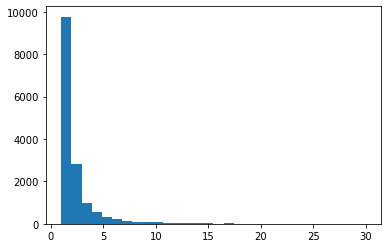

In [88]:
plt.hist([len(cl) for cl in clusters], bins=30,range=(1,30),)

In [89]:
clusters_nonempty = list(clusters_dict.values())

In [90]:
st = datetime.now()
#try to split clusters
clusters_new = []
for clstr_plgn in clusters_nonempty:
    
    #New - Check if all members in cluster belong to same parcel, then do not split.
    if len(set([polygon2parclnum[plgn] for plgn in clstr_plgn if plgn in polygon2parclnum ]))==1:
        clusters_new.append(clstr_plgn)
        continue
        
    if len(clstr_plgn)>=20 and len(clstr_plgn)<30 :
        clusters_new.extend(perform_best_splits(clstr_plgn))
    else:
        clusters_new.append(clstr_plgn)
                            
clusters_new_dict = OrderedDict(enumerate(list(clstr) for clstr in clusters_new if len(clstr)))
datetime.now()-st

datetime.timedelta(seconds=34, microseconds=507623)

In [72]:
len(clusters_new),len(clusters_new_dict)

(17305, 17305)

In [91]:
#check
len(clusters_new),len(clusters_new_dict)

(15694, 15694)

In [92]:
#check
len(clusters_new),len(clusters_new_dict)

(15694, 15694)

In [93]:
# #Vis 3 with transparency for post split clusters
# #Clusters by parcels and neighborhood(nearness + color similarity)
# st= datetime.now()
# img_h_clustered_alpha = annotate_clusters_on_img_new(img_h.copy(), clusters_new_dict, alpha=0.2)
# plt.imsave('fas_img_h_markham_img_overlaid_clustered_after_split_alpha0.2.png', img_h_clustered_alpha)
# print(datetime.now()-st)

### Export clusters as groups of building centroids

In [94]:
# clusters_json_object = json.dumps(clusters_as_centroids, indent = 4)
# with open("SantanaRow_clusters_as_centroids.json", "w") as outfile: 
#     json.dump(clusters_as_centroids, outfile, indent = 4)

In [95]:
clusters_as_centroids = {cln:[shapely_point_to_xy(polygons_ll[plgn].centroid) for plgn in clusters_new_dict[cln]]  for cln in clusters_new_dict } 

In [96]:
clusters_as_plgns = {cln:[polygons_ll[plgn] for plgn in clusters_new_dict[cln]]  for cln in clusters_new_dict } 

In [76]:
len(clusters_as_centroids),len(clusters_as_plgns)

(17305, 17305)

In [97]:
len(clusters_as_centroids),len(clusters_as_plgns)

(15694, 15694)

In [98]:
#verify
clusters_new_dict[17],clusters_as_centroids[17],clusters_as_plgns[17]

([27680, 27675, 27679],
 [(-122.00967231409959, 37.3465629228388),
  (-122.00983189521416, 37.346625479760924),
  (-122.0096618252291, 37.34671812787925)],
  <shapely.geometry.polygon.Polygon at 0x7fd5a37c8f90>])

In [99]:
#verify
[ plg.centroid.coords.xy for plg in clusters_as_plgns[17]]

[(array('d', [-122.00967231409959]), array('d', [37.3465629228388])),
 (array('d', [-122.00983189521416]), array('d', [37.346625479760924])),
 (array('d', [-122.0096618252291]), array('d', [37.34671812787925]))]

### Save in geojson format

In [100]:
#Save if want to cache results
# pkl.dump( fa_results, open( "fa_results.p", "wb" ) )# Clusters as polygons of buildings 

st = datetime.now()
clstr_ids_list = []
clstr_lats_list = []
clstr_lngs_list = []
clstr_plgs_list = []


for clstn in clusters_as_centroids:
    for idx in range(len(clusters_as_centroids[clstn])):
        lng,lat = clusters_as_centroids[clstn][idx]
        plg = clusters_as_plgns[clstn][idx]
        clstr_ids_list.append(clstn)
        clstr_lats_list.append(lat)
        clstr_lngs_list.append(lng)
        clstr_plgs_list.append(plg)
    
df = pd.DataFrame(
    {
     'cluseter_id': clstr_ids_list,
     'lat': clstr_lats_list,
     'lng': clstr_lngs_list,
     'geometry':clstr_plgs_list
    }
) 
datetime.now()-st

import geopandas
gdf = geopandas.GeoDataFrame(df, geometry='geometry')

In [78]:
# Clusters as centroids of buildings 

# st = datetime.now()
# clstr_ids_list = []
# clstr_lats_list = []
# clstr_lngs_list = []

# for clstn in clusters_as_centroids:
#     for lng,lat in clusters_as_centroids[clstn]:
#         clstr_ids_list.append(clstn)
#         clstr_lats_list.append(lat)
#         clstr_lngs_list.append(lng)
    
# df = pd.DataFrame(
#     {
#      'cluseter_id': clstr_ids_list,
#      'lat': clstr_lats_list,
#      'lng': clstr_lngs_list
#     }
# ) 
# datetime.now()-st

# import geopandas
# gdf = geopandas.GeoDataFrame(
#     df, geometry=geopandas.points_from_xy(df.lat, df.lng))

datetime.timedelta(microseconds=21510)

In [101]:
gdf.to_file('Sunnyvale_big_area_clusters_as_polygons_nosplit.geojson', driver="GeoJSON")

In [99]:
print(request_data)

{'bounds': {'south_west': {'lat': 37.328858489991504, 'lng': -122.06266534319472}, 'north_east': {'lat': 37.399259291969024, 'lng': -121.99125421248486}}}


In [100]:
datetime.now()

datetime.datetime(2021, 7, 27, 22, 43, 19, 102840)

## End

In [ ]:
# clstr = clusters_dict[492]
# clstr

# clstr_centers_cr = [ plg_centers_cr[plgn] for plgn in clstr]
# clstr_centers_cr

#  [plgn for plgn in clstr]

# # convert_polygon_to_xy(polygons_cr[454])+convert_polygon_to_xy(polygons_cr[494])
# plgn_ext_pts_cr = []
# for plgn in clstr:
#     plgn_ext_pts_cr.extend(convert_polygon_to_xy(polygons_cr[plgn]))

# plgn_ext_pts_cr

# #find good K is any
# df = pd.DataFrame(data=clstr_centers_cr,columns=['x','y'])



# dist_points_from_cluster_center = []
# K = range(1,12)
# for splits in K:
#     k_model = KMeans(n_clusters=splits)
#     k_model.fit(df)
#     dist_points_from_cluster_center.append(k_model.inertia_)

# dist_points_from_cluster_center

# plt.plot(K, dist_points_from_cluster_center)

# from sklearn.datasets import make_blobs

# # Create dataset with 3 random cluster centers and 1000 datapoints
# x, y = make_blobs(n_samples = 1000, centers = 3, n_features=2, shuffle=True, random_state=31)


# clstr_centers_cr

# #Single Clusters'score
# silhouette_score(np.array(clstr_centers_cr+[(1,1)]), np.array([0]*11+[1]), metric = 'euclidean')

# from sklearn.metrics import silhouette_score

# sil = []
# k2sil = {}
# kmax = 10

# # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(2, kmax+1):
#     kmeans = KMeans(n_clusters = k).fit(np.array(clstr_centers_cr))
#     labels = kmeans.labels_
#     sil_score = silhouette_score(np.array(clstr_centers_cr), labels, metric = 'euclidean')
#     sil.append(sil_score)
#     k2sil[k]= sil_score
    



# k2sil = calculate_silhouette_scores([494, 530, 498, 472, 473, 506, 478,454, 496, 471, 479])

# # np.percentile(list(k2sil.values()), 80)

# k2sil.values()




# percentile_cutoff = np.percentile(list(k2sil.values()), 80)
# percentile_cutoff

# k_candidates = []
# for k in k2sil:
#     if k2sil[k] >= percentile_cutoff:
#         k_candidates.append(k)

# k_candidates


# k2cwss = calculate_WSS_klist([494, 530, 498, 472, 473, 506, 478,454, 496, 471, 479],klist=k_candidates)

# k_final = k_candidates[np.argmin(list(k2cwss.values()))]

# final_clusters = make_k_clusters([494, 530, 498, 472, 473, 506, 478,454, 496, 471, 479], k=k_final)

# final_clusters



# perform_best_splits([494, 530, 498, 472, 473, 506, 478,454, 496, 471, 479])

# sil

# plt.plot(range(2, 11), sil)
# plt.xticks(range(2, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")



# from sklearn.cluster import KMeans

# # function returns WSS score for k values from 1 to kmax
# # def calculate_WSS(points, kmax=5):
# #     sse = []
# #     for k in range(1, kmax+1):
# #         kmeans = KMeans(n_clusters = k).fit(points)
# #         centroids = kmeans.cluster_centers_
# #         pred_clusters = kmeans.predict(points)
# #         curr_sse = 0

# #         # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
# #         for i in range(len(points)):
# #             curr_center = centroids[pred_clusters[i]]
# #             curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

# #         sse.append(curr_sse)
    
# #     return sse

# # def calculate_WSS(clstr, kmax=1):
# #     clstr_centers_cr = [ plg_centers_cr[plgn] for plgn in clstr]
# #     points = np.array(clstr_centers_cr)
# #     sse = []
# #     for k in range(1, kmax+1):
# #         kmeans = KMeans(n_clusters = k).fit(points)
# #         centroids = kmeans.cluster_centers_
# #         pred_clusters = kmeans.predict(points)
# #         curr_sse = 0

# #         # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
# #         for i in range(len(points)):
# #             curr_center = centroids[pred_clusters[i]]
# #             curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

# #         sse.append(curr_sse)
    
# #     return sse

# # def calculate_WSS_klist(clstr_plgn, klist=[1]):
# #     clstr_centers_cr = [ plg_centers_cr[plgn] for plgn in clstr_plgn]
# #     points = np.array(clstr_centers_cr)
# #     sse = OrderedDict()
# #     for k in klist:
# #         kmeans = KMeans(n_clusters = k).fit(points)
# #         centroids = kmeans.cluster_centers_
# #         pred_clusters = kmeans.predict(points)
# #         curr_sse = 0

# #         # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
# #         for i in range(len(points)):
# #             curr_center = centroids[pred_clusters[i]]
# #             curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

# #         sse[k]= curr_sse

# #     return sse

# calculate_WSS(np.array(clstr_centers_cr))



# # def make_k_clusters(points, k=1):
# #     ''' Splits the cluster in k clusters using euclidean distance measure '''
    
# #     kmeans = KMeans(n_clusters = k).fit(points)
# #     pred_clusters = kmeans.predict(points)
    
# #     clusters = []
# #     for l in set(kmeans.labels_):
# #         lidx = list(np.argwhere(pred_clusters==l).reshape(-1))
# #         lclstr = points[lidx].tolist()
# #         clusters.append([center2plgn_cr[tuple(plgn_ctr_cr)] for plgn_ctr_cr in lclstr])
        
# #     return clusters

# def make_k_clusters(plgn_list, k=1):
#     ''' Splits the cluster in k clusters using euclidean distance measure '''
    
#     clstr_centers_cr = [ plg_centers_cr[plgn] for plgn in plgn_list]
#     points = np.array(clstr_centers_cr)
    
#     kmeans = KMeans(n_clusters = k).fit(points)
#     pred_clusters = kmeans.predict(points)
    
#     clusters = []
#     for l in set(kmeans.labels_):
#         lidx = list(np.argwhere(pred_clusters==l).reshape(-1))
#         lclstr = points[lidx].tolist()
#         clusters.append([center2plgn_cr[tuple(plgn_ctr_cr)] for plgn_ctr_cr in lclstr])
        
#     return clusters

# make_k_clusters(points,k=3)

# calculate_WSS([496, 471, 479])

# sum(calculate_WSS([496, 471, 479]) + calculate_WSS([454]) + calculate_WSS([494, 530, 498, 472, 473, 506, 478]))

# sum(calculate_WSS([496, 471, 479,454]) + calculate_WSS([494, 530, 498, 472, 473, 506, 478]))


# lclstr

### Address Single buildings

In [ ]:
#Polygon numbers for 
clustered_alone_plgns = [clusters_dict[cln][0] for cln in clusters_dict if len(clusters_dict[cln])==1]

In [ ]:
print(f'Number clusters with 1 building {len(clustered_alone_plgns)}')

In [ ]:
set([len(nearest_plgns[plgn]) for plgn in clustered_alone_plgns])

In [ ]:
[plgn for plgn in clustered_alone_plgns if len(nearest_plgns[plgn])==0]

In [ ]:
#Convert all polygons to lat,long coords
# parcels_cr = {prcln:convert_polygon_latlng_to_polygon_colrow(parcels_ll[prcln],img_h)  for prcln in parcels_ll}

In [ ]:
# pdf['parcels'] = pdf['geometry'].map(lambda p: convert_polygon_to_xy(p))
# parcels_xy = list(pdf['polylines'].values)
# img_h_clustered_parcels = annotate_polygons_on_image(np.copy(img_h_clustered), polylines_xy,color=(255,255,0))

In [ ]:
# pdft['parcels'] = pdft['geometry'].map(lambda p: convert_polygon_to_xy(p))
# parcels_xy = list(pdft['parcels'].values)
# img_h_clustered_parcels = annotate_polygons_on_image(np.copy(img_h_clustered), parcels_xy,color=(255,255,0))

In [ ]:
# mm = pdft['geometry'].map(lambda pl: isinstance(pl,shapely.geometry.multipolygon.MultiPolygon))

In [ ]:
# np.argmax(mm.values)
# # mm.values

In [ ]:
# pl_cr = convert_polygon_latlng_to_polygon_colrow(pdft['geometry'].iloc[120], img_h_clustered_parcels)

In [ ]:
# pdf.iloc[760]['geometry']

In [ ]:
# plt.imsave('img_h_clustered_parcels.png',img_h_clustered_parcels)

#### Build nearest polygons for each polygons using 360 degree Line of View(LOV)

In [ ]:
#build nearest polygons information for each of the polygons
nearest_plgns_all = find_nearest_polygons(plg_centers_ll,number_of_neighbors=len(plg_centers_ll)-1)

In [ ]:
def find_nearest_polygons_LOV(polygons_ll, number_of_views=36):
    ''' Finds 'k' nearest points for each of polygons
    params:
        plg_centers_dict: dict of <polygon_number, polygon_center>
        number_of_neighbors: number of nearest polygons to find for each polygon (excluding self)
    returns:
        nearest_plgns: dict of <polygon_number: [list of 'number_of_neighbors' polygon_numbers in neighborhood] >'''
    import sklearn
    from sklearn.neighbors import BallTree
    import numpy as np
    from collections import OrderedDict
    
    #array with same index order as index_points keys
    plg_centers = np.array(list(plg_centers_dict.values())) 

    #Build the ball tree of all the records
    tree = BallTree(plg_centers, leaf_size=14)  

    nearest_plgns = OrderedDict({plgn: tree.query(np.array(plg_centers_dict[plgn]).reshape(1,2), k=number_of_neighbors+1)[1][0][1:].tolist() for plgn in plg_centers_dict})
    
    return nearest_plgns

#Find nearest 24 polygons for each of the polygons
nearest_plgns = find_nearest_polygons(plg_centers_ll,number_of_neighbors=24) # mappings as <plgn:[list of neighbor plgns> 

In [ ]:
rotation_degrees=36 
lovs_count = int(360/rotation_degrees)

In [ ]:
lovs = [] #list of lines
l0 = loads('LINESTRING (50 50, 50 0)')
for i in range(lovs_count):
    lovs.append(affinity.rotate(l0, -i*rotation_degrees, (50, 50)))    

In [ ]:
lovs[0]

In [ ]:
from geopandas import GeoSeries
g = GeoSeries(lovs)

In [ ]:
g.plot()

In [ ]:
#get l0 for polygon
def get_first_line(plg,line_length=5000):
    ''' gets the l0 starting from center of polygon to north most point '''    
    #plg = polygons_cr[0]
    ctr = shapely_shape_to_point(plg)
    ctr = int(ctr[0]),int(ctr[1])
    north_point = (ctr[0],ctr[1]-line_length)
    l0 = LineString([ctr, north_point])
    return l0

def get_lovs(plg, rotation_degrees=36):
    ''' Rotates the passed line and creates as many lines possible with rotation_degrees '''
    rotation_degrees=36 
    lovs_count = int(360/rotation_degrees)   
    ctr = shapely_shape_to_point(plg)
    ctr = int(ctr[0]),int(ctr[1])    
    lovs = [] #list of lines
    l0 = get_first_line(plg)
    for i in range(lovs_count):
        lovs.append(affinity.rotate(l0, -i*rotation_degrees, (ctr[0], ctr[1])))
    from geopandas import GeoSeries
    gs = GeoSeries(lovs)
    return gs

In [ ]:
lovs_gs = get_lovs(polygons_cr[12])

In [ ]:
lovs_gs.plot()

In [ ]:
max([len(nearest_plgns[plgn]) for plgn in nearest_plgns])

In [ ]:
plg = polygons_cr[10]

In [ ]:
find_closest_nbrs(plg_centers_cr[10])

In [ ]:
center2plgn_cr[plg_centers_cr[10]]

In [ ]:
from shapely.wkt import loads
from shapely import affinity
from shapely.geometry import LineString

poly = loads('POLYGON ((140 270, 300 270, 350 200, 300 150, 140 150, 100 200, 140 270))')
line = loads('LINESTRING (370 290, 270 120)')

intersection = poly.exterior.intersection(line)

In [ ]:
if intersection.is_empty:
    print("shapes don't intersect")
elif intersection.geom_type.startswith('Multi') or intersection.geom_type == 'GeometryCollection':
    for shp in intersection:
        print(shp)
else:
    print(intersection)

In [ ]:
poly.contains(intersection[1]),line.intersects(intersection[1])

In [ ]:
poly.intersects(line)

In [ ]:
tc = np.ones((100,100,3),dtype=np.uint8)*255
plt.imshow(tc)

In [ ]:
l1 = loads('LINESTRING (50 50, 50 0)')
draw_line??

In [ ]:
draw_line(tc, (50,50),(50,0))
plt.imshow(tc)

In [ ]:
# Rotate from origin at (1, 1)
l1_rotated = affinity.rotate(l1, -30, (50, 50))

In [ ]:
l1

In [ ]:
l1_rotated